In [128]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [129]:

conn = sqlite3.connect(r'C:\Users\opper\Master-Arbeit\data\preprocessed\pv_forecast.db')
start_time = '2024-01-01 00:00:00'
end_time = '2024-01-10 00:00:00'
specific_location = 'Bielefeld'

In [130]:
query = f"""
SELECT "Date time", shortwave_radiation_tilted, Temperature, "kWh/kWp"
FROM pv_weather_data
WHERE "Date time" BETWEEN '{start_time}' AND '{end_time}'
  AND Location = '{specific_location}'
ORDER BY "Date time" ASC
"""
# Daten abrufen und in ein DataFrame laden
df = pd.read_sql(query, conn)
conn.close()

# Ausgabe des DataFrames zum Überprüfen
print(df)

                     Date time  shortwave_radiation_tilted  Temperature  \
0    2024-01-01 00:00:00+00:00                         0.0          8.0   
1    2024-01-01 00:15:00+00:00                         0.0          7.6   
2    2024-01-01 00:30:00+00:00                         0.0          7.3   
3    2024-01-01 00:45:00+00:00                         0.0          7.3   
4    2024-01-01 01:00:00+00:00                         0.0          7.6   
..                         ...                         ...          ...   
859  2024-01-09 22:45:00+00:00                         0.0         -5.6   
860  2024-01-09 23:00:00+00:00                         0.0         -6.3   
861  2024-01-09 23:15:00+00:00                         0.0         -6.0   
862  2024-01-09 23:30:00+00:00                         0.0         -5.3   
863  2024-01-09 23:45:00+00:00                         0.0         -5.3   

     kWh/kWp  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
..       

In [131]:
df["Date time"] = pd.to_datetime(df["Date time"])
df = df.sort_values("Date time")
df.set_index("Date time", inplace=True)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [132]:
time_steps = 672  # 7 Tage = 672 Zeitschritte (15-Minuten-Intervalle)
future_steps = 96  # 24h Vorhersage (96 Zeitschritte)

feature_cols = [0, 1, 2]
target_col = 0

def create_sequences(data, time_steps, future_steps, feature_cols, target_col):
    X_enc, X_dec, y = [], [], []
    for i in range(len(data) - time_steps - future_steps):
        # Encoder bekommt ALLE Features (PV, Temperatur, Solarstrahlung)
        X_enc.append(data[i:i+time_steps, feature_cols])
        # Decoder bekommt NUR zukünftige Wetterdaten (Temperatur, Solarstrahlung)
        X_dec.append(data[i+time_steps:i+time_steps+future_steps, 1:])  # Spalten 1 & 2 (ohne PV)
        # Zielwerte (nur PV-Leistung in der Zukunft)
        y.append(data[i+time_steps:i+time_steps+future_steps, target_col])
    return np.array(X_enc), np.array(X_dec), np.array(y)

X_enc, X_dec, y = create_sequences(df_scaled, time_steps, future_steps, feature_cols, target_col)

print(f"Anzahl der Datenpunkte: {len(df_scaled)}")


Anzahl der Datenpunkte: 864


In [133]:
X_enc_train, X_enc_test, X_dec_train, X_dec_test, y_train, y_test = train_test_split(X_enc, X_dec, y, test_size=0.2, random_state=42)

latent_dim = 128 

# Encoder
encoder_inputs = Input(shape=(time_steps, len(feature_cols)))  # Alle Features
encoder = LSTM(latent_dim, return_state=True)  
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(future_steps, X_dec.shape[2]))  # Nur Wetterdaten
decoder_lstm = LSTM(latent_dim, return_sequences=True)  # Zukünftige Wetterdaten verarbeiten
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)  # Start mit Encoder-State
decoder_outputs = TimeDistributed(Dense(1))(decoder_outputs)  # PV-Leistung vorhersagen




Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 822ms/step - loss: 3.8108e-04 - val_loss: 4.6628e-04
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - loss: 4.2227e-04 - val_loss: 4.2548e-04
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - loss: 3.6515e-04 - val_loss: 4.3377e-04
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - loss: 3.7273e-04 - val_loss: 3.3224e-04
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - loss: 3.1416e-04 - val_loss: 3.2058e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - loss: 2.9795e-04 - val_loss: 3.1864e-04
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - loss: 2.8800e-04 - val_loss: 3.1458e-04
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - loss: 2.8445e-04 - val_loss: 2.8936e-04
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 2.7401e-04 - val_loss: 2.9090e-04
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - loss: 2.6407e-04 - val_loss: 2.8832e-04
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - loss: 2.7059e-04 - val_los

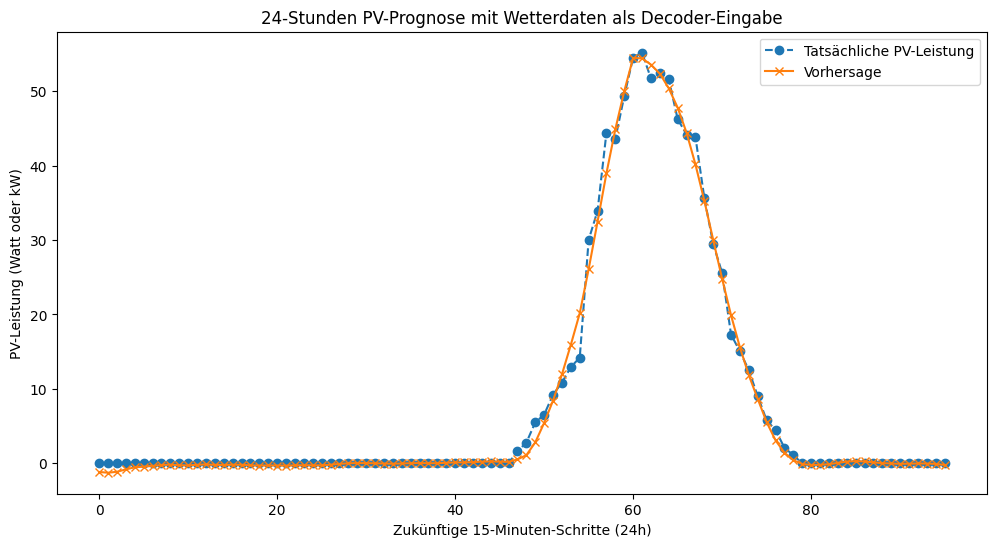

In [139]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="mse")

# 🌞 5️⃣ Modell trainieren 🌞
history = model.fit([X_enc_train, X_dec_train], y_train, epochs=50, batch_size=32, validation_data=([X_enc_test, X_dec_test], y_test))

# 🌞 7️⃣ Vorhersage 🌞
y_pred = model.predict([X_enc_test, X_dec_test])

# 🌞 8️⃣ Debugging: MinMaxScaler überprüfen 🌞
print("Scaler min:", scaler.data_min_)
print("Scaler max:", scaler.data_max_)

# 🌞 9️⃣ Korrekte Rücktransformation 🌞
# Sicherstellen, dass y_test die richtige Form hat
y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])  # (num_samples, 96)
y_pred_reshaped = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])  # (num_samples, 96)

# Leeres Array mit der gleichen Anzahl an Spalten wie df_scaled
empty_array = np.zeros((y_test.shape[0] * y_test.shape[1], df_scaled.shape[1]))

# Fülle NUR die erste Spalte mit den echten PV-Werten
empty_array[:, 0] = y_test_reshaped.reshape(-1, 1).squeeze()

# Rücktransformation
y_test_original = scaler.inverse_transform(empty_array)[:, 0]
y_test_original = y_test_original.reshape(y_test.shape[0], y_test.shape[1])

# Dasselbe für die Vorhersagewerte
empty_array[:, 0] = y_pred_reshaped.reshape(-1, 1).squeeze()
y_pred_original = scaler.inverse_transform(empty_array)[:, 0]
y_pred_original = y_pred_original.reshape(y_pred.shape[0], y_pred.shape[1])

# 🌞 10️⃣ Vergleich mit Original-Datenbank-Werten 🌞
print("Original PV-Werte aus der Datenbank:", df["kWh/kWp"].values[:10])
print("Rücktransformierte PV-Werte:", y_test_original[:10])

# 🌞 11️⃣ Ergebnisse visualisieren 🌞
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[0], label="Tatsächliche PV-Leistung", marker="o", linestyle="dashed")
plt.plot(y_pred_original[0], label="Vorhersage", marker="x")
plt.xlabel("Zukünftige 15-Minuten-Schritte (24h)")
plt.ylabel("PV-Leistung (Watt oder kW)")  # Einheit je nach Daten
plt.legend()
plt.title("24-Stunden PV-Prognose mit Wetterdaten als Decoder-Eingabe")
plt.show()

In [141]:
print("Original PV-Werte aus der Datenbank:", df["kWh/kWp"].values[672:768])



print("Rücktransformierte PV-Werte:", y_test_original[0:96])








Original PV-Werte aus der Datenbank: [0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.0008  0.00134 0.00268 0.0069  0.00617
 0.00854 0.01299 0.01579 0.01655 0.02007 0.02506 0.02875 0.02447 0.03641
 0.03471 0.03092 0.03915 0.04203 0.03298 0.03166 0.03399 0.03419 0.0248
 0.02788 0.02302 0.02217 0.0128  0.01132 0.00605 0.00309 0.00132 0.00034
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     ]
Rücktransformierte PV-Werte: [[ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  0.   